In [1]:

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from sklearn.preprocessing import normalize
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

C:\app\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [4]:
# doc2vec_model = gensim.models.doc2vec.Doc2Vec.load('docembeddings_dim_400_window_10')

In [7]:
with open('Doc2Vec_X_data.pkl', 'rb') as f:
    X_data = pickle.load(f)
with open('Doc2Vec_y_data_all_toxicity.pkl', 'rb') as f:
    y_data = pickle.load(f)
with open('Doc2Vec_y_data_colitis.pkl', 'rb') as f:
    y_data_colitis = pickle.load(f)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_colitis, test_size=0.2)

In [110]:
list(y_data_colitis).count(0)

700

In [129]:
def smart_sample(X_train, y_train, num_positive, num_negative):
    X_train_positives = np.asarray([X_train[i] for i in range(X_train.shape[0]) if y_train[i] == 1])
    y_train_positives = np.asarray([y_train[i] for i in range(y_train.shape[0]) if y_train[i] == 1])
    X_train_negatives = np.asarray([X_train[i] for i in range(X_train.shape[0]) if y_train[i] == 0])
    y_train_negatives = np.asarray([y_train[i] for i in range(y_train.shape[0]) if y_train[i] == 0])
    
    percent_positive = num_positive/X_train_positives.shape[0]
    percent_negative = num_negative/X_train_negatives.shape[0]
    
    mask_positive = np.random.choice([False, True], len(X_train_positives), p=[1-percent_positive, percent_positive])
    mask_negative = np.random.choice([False, True], len(X_train_negatives), p=[1-percent_negative, percent_negative])
    
    X_train_positives_sampled = X_train_positives[mask_positive]
    y_train_positives_sampled = y_train_positives[mask_positive]
    X_train_negatives_sampled = X_train_negatives[mask_negative]
    y_train_negatives_sampled = y_train_negatives[mask_negative]
    
    X_data_smart_sampled = np.concatenate((X_train_positives_sampled, X_train_negatives_sampled), axis=0)
    y_data_smart_sampled = np.concatenate((y_train_positives_sampled, y_train_negatives_sampled), axis=0)
    
    data_sampled = np.column_stack( (X_data_smart_sampled, y_data_smart_sampled) )
    np.random.shuffle(data_sampled)
    X_train_sampled, y_train_sampled = data_sampled[:, 0 : data_sampled.shape[1]-1], data_sampled[:, data_sampled.shape[1]-1].ravel()

    return X_train_sampled, y_train_sampled

    

In [196]:
# there are 66 1's in training data
X_train_sampled, y_train_sampled = smart_sample(X_train, y_train, 61, 61)

In [197]:
y_train_sampled

array([0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.])

In [44]:
def plot_history(history):
    ''' A method taken from https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding that
        effectively plots the training and validation accuracy and loss data and diplays it. '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [84]:
weights = {0:0.01, 1:100000}

In [85]:
patience = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='min')
filepath = 'Doc2VecNN_CW.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

#Creation of the neural network with the pretrained embedding matrix.
model = Sequential()
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])#, keras_metrics.precision(), keras_metrics.recall()])
#model.summary()

In [86]:
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=60,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    class_weight=weights,
                   callbacks=[patience, checkpoint])

Train on 623 samples, validate on 156 samples
Epoch 1/60

Epoch 00001: val_loss improved from inf to 0.37150, saving model to Doc2VecNN_CW.h5
 - 3s - loss: 0.4036 - acc: 0.8812 - val_loss: 0.3715 - val_acc: 0.8846
Epoch 2/60

Epoch 00002: val_loss did not improve from 0.37150
 - 2s - loss: 0.3471 - acc: 0.9021 - val_loss: 0.3850 - val_acc: 0.8846
Epoch 3/60

Epoch 00003: val_loss did not improve from 0.37150
 - 2s - loss: 0.3211 - acc: 0.9021 - val_loss: 0.3717 - val_acc: 0.8782
Epoch 4/60

Epoch 00004: val_loss did not improve from 0.37150
 - 2s - loss: 0.3043 - acc: 0.9037 - val_loss: 0.3947 - val_acc: 0.8846
Epoch 5/60

Epoch 00005: val_loss did not improve from 0.37150
 - 2s - loss: 0.2870 - acc: 0.9117 - val_loss: 0.3892 - val_acc: 0.8846
Epoch 6/60

Epoch 00006: val_loss did not improve from 0.37150
 - 2s - loss: 0.2864 - acc: 0.9037 - val_loss: 0.4058 - val_acc: 0.8846
Epoch 7/60

Epoch 00007: val_loss did not improve from 0.37150
 - 2s - loss: 0.2426 - acc: 0.9037 - val_loss: 0

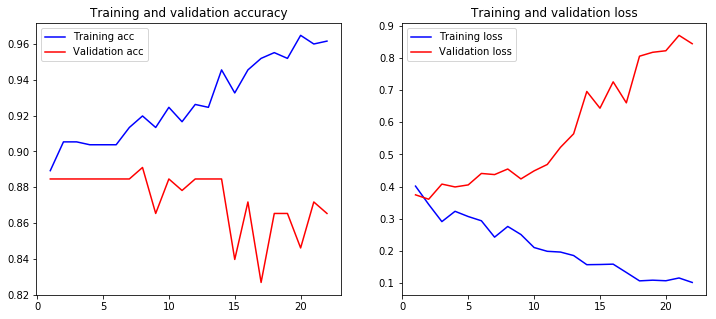

In [78]:
plot_history(history)

In [79]:
#model.save('doc2vec_neuralnetwork_classifier.h5') 
model = keras.models.load_model(filepath)

In [101]:
y_pred = np.around(model.predict(X_test, batch_size=32), decimals=0)
y_pred_thresh = [i for i in y_pred if i > 0.2]

In [95]:
y_pred.ravel()

array([0.006, 0.002, 0.396, 0.036, 0.848, 0.034, 0.029, 0.01 , 0.003,
       0.   , 0.009, 0.   , 0.001, 0.   , 0.007, 0.034, 0.188, 0.003,
       0.001, 0.002, 0.   , 0.   , 0.001, 0.019, 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.001, 0.372, 0.246, 0.111, 0.   , 0.763,
       0.   , 0.   , 0.075, 0.138, 0.   , 0.   , 0.005, 0.   , 0.084,
       0.245, 0.016, 0.003, 0.011, 0.001, 0.001, 0.001, 0.002, 0.012,
       0.012, 0.008, 0.008, 0.209, 0.025, 0.007, 0.   , 0.094, 0.   ,
       0.013, 0.036, 0.001, 0.079, 0.191, 0.   , 0.047, 0.   , 0.316,
       0.155, 0.21 , 0.   , 0.036, 0.   , 0.   , 0.655, 0.148, 0.   ,
       0.002, 0.   , 0.147, 0.   , 0.42 , 0.01 , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.001, 0.008, 0.062, 0.001, 0.001, 0.   , 0.001,
       0.092, 0.003, 0.742, 0.   , 0.018, 0.205, 0.06 , 0.322, 0.008,
       0.   , 0.47 , 0.   , 0.029, 0.001, 0.   , 0.   , 0.001, 0.   ,
       0.059, 0.001, 0.015, 0.312, 0.   , 0.168, 0.01 , 0.   , 0.   ,
       0.643, 0.256,

In [91]:
y_test

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [92]:
print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.892617  0.963768  0.926829       138
           1   0.285714  0.111111  0.160000        18

    accuracy                       0.865385       156
   macro avg   0.589166  0.537440  0.543415       156
weighted avg   0.822590  0.865385  0.838349       156



In [96]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

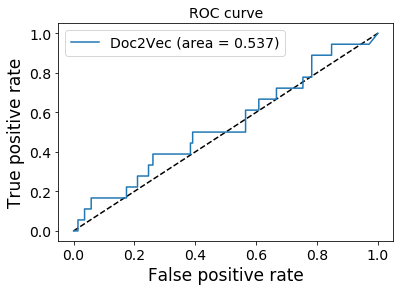

In [105]:
SMALL_SIZE = 14
MEDIUM_SIZE = 17
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Doc2Vec (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [166]:
report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.43      0.07      0.12        84
           1       0.45      0.89      0.60        72

   micro avg       0.45      0.45      0.45       156
   macro avg       0.44      0.48      0.36       156
weighted avg       0.44      0.45      0.34       156



In [3]:
def show_confusion_matrix(confusion_matrix):
    SMALL_SIZE = 14
    MEDIUM_SIZE = 17
    BIGGER_SIZE = 50

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    ax = plt.subplot()
    confusion_matrix = normalize(confusion_matrix, axis=1, norm='l1')
    sns.heatmap(confusion_matrix ,annot=True, ax = ax, cmap='Reds')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix', fontsize=23)
    ax.xaxis.set_ticklabels(['Normal', 'Colitis'])
    ax.yaxis.set_ticklabels(['Normal', 'Colitis'], va='center')
    #plt.matshow(confusion_matrix_array)
    #plt.colorbar()
    plt.show()

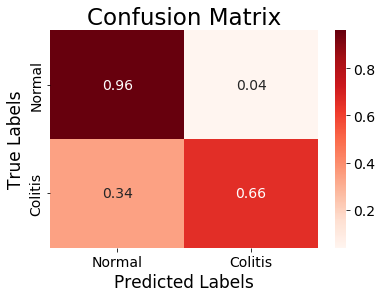

In [4]:
precision=0.6508044733
recall=0.657143
neg = 700
pos = 79
tp = pos * recall
fn = pos - tp
fp = (tp - precision * tp)/precision
tn = neg-fp
show_confusion_matrix([[tn, fp], [fn, tp]])

In [126]:
def accuracy(predict, validation):
    total = validation.shape[0]
    correct = 0
    for i in range(predict.shape[0]):
        if predict[i] == validation[i]:
            correct += 1
    return correct/total

In [127]:
predict_thresh = np.where(predict > 0.4, 1, 0)
accuracy(predict_thresh, y_test)




0.5705128205128205